In [1]:
# miscellaneous
import matplotlib.pyplot as plt

from glob import glob #library that helps us search for files
import scipy
import random
from datetime import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from scipy.special import inv_boxcox
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

# hyperparameter tuning
from hyperopt import hp
from hyperopt import tpe, hp, fmin, STATUS_OK,Trials, partial

# preprocessing
from category_encoders import OneHotEncoder,TargetEncoder,OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, PowerTransformer,LabelEncoder, MaxAbsScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score,cross_val_predict, KFold, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer, PowerTransformer,LabelEncoder, MaxAbsScaler, RobustScaler

# models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression,BayesianRidge, ElasticNet, Lasso
from sklearn.dummy import DummyClassifier
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import clone
import lightgbm as lgb

# metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import log_loss, confusion_matrix, classification_report, precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils.validation import check_is_fitted

# feature selection / data sampling
from sklearn.feature_selection import RFE, SelectKBest, f_classif, SelectFromModel, VarianceThreshold
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.inspection import permutation_importance

# saving model
import pickle,joblib
import boto3

# data settings
pd.pandas.set_option('display.max_rows',None)
pd.pandas.set_option('display.max_columns',None)
pd.set_option('display.max_colwidth', None)


from sklearn import set_config
set_config(transform_output = 'pandas')

import warnings
warnings.simplefilter(action="ignore")


import json

# custom package
import importlib
import package
importlib.reload(package)

from package.data_retrieval.data_retrieval import s3_retrieval, write_to_s3
from package.eda.data_exploration import correlation
from package.training.model_training import model_evaluation, split_data_by_type, performance_plots
from package.preprocessing.data_preprocessing import create_pipeline, winsorize, percentile_imputer, random_sample_imputer, count_encoder 

# Read Config

In [2]:
config_path = "C:/Users/Oamen/OneDrive/Documents/DATA PROJECTS/Insurance_claim_prediction_porto/config.json"

In [3]:
# Opening JSON file
with open(config_path) as file:
    
    config = json.load(file)

# Read Data

In [4]:
# get access key
secret = pd.read_csv("C:/Users/Oamen/Downloads/jupyter_iam_accessKeys.csv")

In [5]:
# create S3 client object 
s3_client = boto3.client('s3',aws_access_key_id=secret['Access key ID'][0],aws_secret_access_key=secret['Secret access key'][0])

In [6]:
bucket_name = config['EDA']['bucket_name'] 

In [7]:
# retrieve data
full_train_df = s3_retrieval(s3_client, bucket_name, config['Model_Selection']['Input_data']['full_train'])

Retrieved object
Read bytes
Success!


In [8]:
#reduced_train_df = s3_retrieval(s3_client, bucket_name, reduced_train_new_key)

In [9]:
validation_df = s3_retrieval(s3_client, bucket_name, config['Model_Selection']['Input_data']['validation'])

Retrieved object
Read bytes
Success!


In [10]:
test_df = s3_retrieval(s3_client, bucket_name, config['Model_Selection']['Input_data']['test'])

Retrieved object
Read bytes
Success!


# Training Preprocessor

## Preprocessor - Experiment 1

1. Missing Values: Simple
2. Encoding: One-Hot
3. Transformation: Log
4. Outliers: Winsorize(0.95-0.05)
5. Scaling: StandardScaler
6. Resampling: SMOTE
7. Feature Selection: Enet Coefs

In [11]:
categorical_exp1, numerical_exp1, xtrain_exp1, ytrain_exp1 = split_data_by_type(full_train_df, config['EDA']['target'])

In [12]:
categorical_exp1, numerical_exp1, xvalidation_exp1, yvalidation_exp1 = split_data_by_type(validation_df, config['EDA']['target'])

In [13]:
num_pipeline_exp1 = Pipeline([
    ('transformer', FunctionTransformer(np.log1p)),
    ('imputer', SimpleImputer(strategy = 'median')),
    ('winsorize', FunctionTransformer(winsorize)),
    ('scaler', StandardScaler()),  
])

cat_pipeline_exp1 = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OneHotEncoder()),
    
])

In [14]:
pipeline_exp1 = create_pipeline(num_pipeline_exp1, numerical_exp1, cat_pipeline_exp1, categorical_exp1)

In [15]:
xtrain_exp1 = pipeline_exp1.fit_transform(xtrain_exp1)

In [16]:
xvalidation_exp1 = pipeline_exp1.transform(xvalidation_exp1)

In [17]:
# smote

smote = SMOTE()

In [18]:
xtrain_exp1, ytrain_exp1 = smote.fit_resample(xtrain_exp1, ytrain_exp1)

In [19]:
# feature selection - Enet Coefs

enet = ElasticNet(l1_ratio = 0.5, alpha = 0.01)

enet.fit(xtrain_exp1, ytrain_exp1)

ElasticNet(alpha=0.01)

In [20]:
imp_columns1 = dict(zip(xtrain_exp1.columns, enet.coef_))

In [21]:
selected_columns_exp1 = [column for column, value in imp_columns1.items() if abs(value) > 0]

len(selected_columns_exp1)

33

In [22]:
xtrain_exp1 = xtrain_exp1[selected_columns_exp1]

xvalidation_exp1 = xvalidation_exp1[selected_columns_exp1]

### Hyperparameter Tuning - Exp 1

#### Random Forest

In [23]:
# create the search space for an over fitting model

search_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 500, 1),
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.quniform('max_depth', 2, 30, 1),
    'min_samples_split': hp.quniform('min_samples_split', 4, 30, 1),
    'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0.0, 0.5),
    'max_leaf_nodes': hp.quniform('max_leaf_nodes',8,30,1),
    'warm_start': hp.choice('warm_start', [True, False]),
    'class_weight': hp.choice('class_weight', ['balanced', 'balanced_subsample']),
    'ccp_alpha': hp.uniform('ccp_alpha', 0.0, 0.9)
   
}

In [24]:
def objective(params, n_folds, x, y):
    
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['max_leaf_nodes'] = int(params['max_leaf_nodes'])
    

    model = RandomForestClassifier(**params, random_state = 0)
    
    scores = cross_val_score(model, x, y, cv = n_folds, scoring = 'f1', error_score='raise')
    
    max_score = max(scores)
    
    # to minimize
    loss = 1 - max_score
    
    return {'loss':loss,
           'params':params,
           'status': STATUS_OK}

In [25]:
# optimize with the TPE algorithm
trials_0 = Trials()
n_folds = 4

best = fmin(fn = partial(objective, n_folds = n_folds,
                         x = xtrain_exp1, y = ytrain_exp1),
           space = search_space, algo = tpe.suggest, max_evals = 8, trials = trials_0,
           )

100%|█████████████████████████████████████████████| 8/8 [2:47:08<00:00, 1253.58s/trial, best loss: 0.33333150993660055]


In [26]:
print(best)

{'ccp_alpha': 0.3162481979164081, 'class_weight': 1, 'criterion': 0, 'max_depth': 3.0, 'max_leaf_nodes': 22.0, 'min_samples_split': 8.0, 'min_weight_fraction_leaf': 0.4925356041107436, 'n_estimators': 281.0, 'warm_start': 1}


In [27]:
print(trials_0.best_trial['result']['loss'])

0.33333150993660055


#### LightGBM

In [28]:
search_space = {
    'num_leaves': hp.quniform('num_leaves', 2,31,1),
    'max_depth': hp.quniform('max_depth', 2,31,1),
    'n_estimators': hp.quniform('n_estimators', 2,100,1),
    'min_child_samples': hp.quniform('min_child_samples', 20,100,1),
    'reg_alpha': hp.uniform('reg_alpha', 0.01, 0.9),
    'reg_lambda': hp.uniform('reg_lambda', 0.01, 0.9),    
}

In [29]:
def objective(params, n_folds, x, y):
    
    params['num_leaves'] = int(params['num_leaves'])
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_samples'] = int(params['min_child_samples'])
    
    
    
    model = lgb.LGBMClassifier(**params, random_state = 0)
    
    scores = cross_val_score(model, x, y, cv = n_folds, scoring = 'f1', error_score='raise')
    
    max_score = max(scores)
    
    # to minimize
    loss = 1 - max_score
    
    return {'loss':loss,
           'params':params,
           'status': STATUS_OK}

In [30]:
# optimize with the TPE algorithm
trials_1 = Trials()
n_folds = 4

best = fmin(fn = partial(objective, n_folds = n_folds,
                         x = xtrain_exp1, y = ytrain_exp1),
           space = search_space, algo = tpe.suggest, max_evals = 8, trials = trials_1,
           )

[LightGBM] [Info] Number of positive: 365618, number of negative: 365617                                               
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.198828 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8193                                                                                      
[LightGBM] [Info] Number of data points in the train set: 731235, number of used features: 33                          
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000003                                         
[LightGBM] [Info] Start training from score 0.000003                                                                   
[LightGBM] [Info] Number of positive: 365618, number of negative: 365617                                               
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.160133 seconds

[LightGBM] [Info] Total Bins 8189                                                                                      
[LightGBM] [Info] Number of data points in the train set: 731235, number of used features: 33                          
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499999 -> initscore=-0.000003                                        
[LightGBM] [Info] Start training from score -0.000003                                                                  
[LightGBM] [Info] Number of positive: 365617, number of negative: 365618                                               
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174258 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8189                                                                                      
[LightGBM] [Info] Number of data points in the train set: 731235, number of used features: 33         

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf                                             
[LightGBM] [Info] Number of positive: 365618, number of negative: 365617                                               
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163564 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8193                                                                                      
[LightGBM] [Info] Number of data points in the train set: 731235, number of used features: 33                          
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500001 -> initscore=0.000003                                         
[LightGBM] [Info] Start training from score 0.000003                                                                   
[LightGBM] [Info] Number of positive: 365618, number of negative: 365617                              

[LightGBM] [Info] Total Bins 8189                                                                                      
[LightGBM] [Info] Number of data points in the train set: 731235, number of used features: 33                          
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499999 -> initscore=-0.000003                                        
[LightGBM] [Info] Start training from score -0.000003                                                                  
[LightGBM] [Info] Number of positive: 365617, number of negative: 365618                                               
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183565 seconds.                
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8189                                                                                      
[LightGBM] [Info] Number of data points in the train set: 731235, number of used features: 33         

In [31]:
print(best)

{'max_depth': 18.0, 'min_child_samples': 24.0, 'n_estimators': 69.0, 'num_leaves': 18.0, 'reg_alpha': 0.3213689953796897, 'reg_lambda': 0.3787078530734701}


In [32]:
print(trials_1.best_trial['result']['loss'])

4.5130982419538945e-05


#### Xgboost

In [33]:
search_space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'max_depth': hp.quniform('max_depth', 3, 15, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'scale_pos_weight': hp.quniform('scale_pos_weight', 1, 10, 1),
}

In [34]:
def objective(params, n_folds, x, y):
    
    params['scale_pos_weight'] = int(params['scale_pos_weight'])
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params['min_child_weight'] = int(params['min_child_weight'])
    
    model = xgb.XGBClassifier(**params, random_state = 0)
    
    scores = cross_val_score(model, x, y, cv = n_folds, scoring = 'f1', error_score='raise')
    
    max_score = max(scores)
    
    # to minimize
    loss = 1 - max_score
    
    return {'loss':loss,
           'params':params,
           'status': STATUS_OK}

In [35]:
#  optimize with the TPE algorithm
trials_x = Trials()
n_folds = 4

best = fmin(fn = partial(objective, n_folds = n_folds,
                         x = xtrain_exp1, y = ytrain_exp1),
           space = search_space, algo = tpe.suggest, max_evals = 8, trials = trials_x,
           )

100%|███████████████████████████████████████████| 8/8 [6:17:32<00:00, 2831.60s/trial, best loss: 7.384251852216028e-05]


In [36]:
print(best)

{'gamma': 4.290075338542718, 'learning_rate': 0.037516227414070166, 'max_depth': 10.0, 'min_child_weight': 7.0, 'n_estimators': 381.0, 'reg_alpha': 0.6235049647917035, 'reg_lambda': 0.03172357049992702, 'scale_pos_weight': 3.0}


In [37]:
print(trials_x.best_trial['result']['loss'])

7.384251852216028e-05


## Preprocessor - Experiment 2

1. Missing Values: Percentile Imputation
2. Encoding: Ordinal
3. Transformation: Sqrt
4. Outliers: Winsorize(0.95-0.05)
5. Scaling: RobustScaler
6. Resampling: ADASYN
7. Feature Selection: SelectFromModel

In [38]:
categorical_exp2, numerical_exp2, xtrain_exp2, ytrain_exp2 = split_data_by_type(full_train_df, config['EDA']['target'])

categorical_exp2, numerical_exp2, xvalidation_exp2, yvalidation_exp2 = split_data_by_type(validation_df, config['EDA']['target'])

In [39]:
num_pipeline_exp2 = Pipeline([
    ('transformer', FunctionTransformer(np.sqrt)),
    ('imputer', FunctionTransformer(percentile_imputer)),
    ('winsorize', FunctionTransformer(winsorize)),
    ('scaler', RobustScaler()),  
])

cat_pipeline_exp2 = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OrdinalEncoder()),
    
])

In [40]:
pipeline_exp2 = create_pipeline(num_pipeline_exp2, numerical_exp2, cat_pipeline_exp2, categorical_exp2)

In [41]:
xtrain_exp2 = pipeline_exp2.fit_transform(xtrain_exp2)

In [42]:
xvalidation_exp2 = pipeline_exp2.transform(xvalidation_exp2)

In [43]:
# adasyn

adasyn = ADASYN()

In [44]:
xtrain_exp2, ytrain_exp2 = adasyn.fit_resample(xtrain_exp2, ytrain_exp2)

In [45]:
rf = RandomForestClassifier()

selector = SelectFromModel(rf, threshold=0.0001).fit(xtrain_exp2, ytrain_exp2)

In [46]:
selected_columns_exp2 = xtrain_exp2.columns[selector.get_support()]

len(selected_columns_exp2)

51

In [47]:
xtrain_exp2 = xtrain_exp2[selected_columns_exp2]

xvalidation_exp2 = xvalidation_exp2[selected_columns_exp2]

### Hyperparameter Tuning - Exp 2

#### Random Forest

In [48]:
# create the search space for an over fitting model

search_space = {
    'n_estimators': hp.quniform('n_estimators', 10, 500, 1),
    'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.quniform('max_depth', 2, 30, 1),
    'min_samples_split': hp.quniform('min_samples_split', 4, 30, 1),
    'min_weight_fraction_leaf': hp.uniform('min_weight_fraction_leaf', 0.0, 0.5),
    'max_leaf_nodes': hp.quniform('max_leaf_nodes',8,30,1),
    'warm_start': hp.choice('warm_start', [True, False]),
    'class_weight': hp.choice('class_weight', ['balanced', 'balanced_subsample']),
    'ccp_alpha': hp.uniform('ccp_alpha', 0.0, 0.9)
   
}

In [49]:
def objective(params, n_folds, x, y):
    
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['max_leaf_nodes'] = int(params['max_leaf_nodes'])
    
    
    model = RandomForestClassifier(**params, random_state = 0)
    
    scores = cross_val_score(model, x, y, cv = n_folds, scoring = 'f1', error_score='raise')
    
    max_score = max(scores)
    
    # to minimize
    loss = 1 - max_score
    
    return {'loss':loss,
           'params':params,
           'status': STATUS_OK}

In [50]:
def objective(params, n_folds, x, y):
    
    params['n_estimators'] = int(params['n_estimators'])
    params['max_depth'] = int(params['max_depth'])
    params['min_samples_split'] = int(params['min_samples_split'])
    params['max_leaf_nodes'] = int(params['max_leaf_nodes'])
    
    
    model = RandomForestClassifier(**params, random_state = 0)
    
    scores = cross_val_score(model, x, y, cv = n_folds, scoring = 'f1', error_score='raise')
    
    max_score = max(scores)
    
    # to minimize
    loss = 1 - max_score
    
    return {'loss':loss,
           'params':params,
           'status': STATUS_OK}

In [51]:
# optimize with the TPE algorithm
trials_2 = Trials()
n_folds = 4

best = fmin(fn = partial(objective, n_folds = n_folds,
                         x = xtrain_exp2, y = ytrain_exp2),
           space = search_space, algo = tpe.suggest, max_evals = 8, trials = trials_2,
           )

100%|██████████████████████████████████████████████| 8/8 [3:25:55<00:00, 1544.48s/trial, best loss: 0.3305379866995021]


In [52]:
print(trials_2.best_trial['result']['loss'])

0.3305379866995021


In [53]:
config['Hyperparameter Tuning'] = {}
config['Hyperparameter Tuning']['best_hyperparameters'] = {}


lightgbm_best = {'max_depth': 13.0, 'min_child_samples': 45.0, 'n_estimators': 82.0, 'num_leaves': 28.0, 'reg_alpha': 0.8485727275388625, 'reg_lambda': 0.25697353165485826}
randomforest_best = {'ccp_alpha': 0.8355154331803291, 'class_weight': 0, 'criterion': 0, 'max_depth': 25.0, 'max_leaf_nodes': 10.0, 'min_samples_split': 16.0, 'min_weight_fraction_leaf': 0.03164012540078487, 'n_estimators': 251.0, 'warm_start': 0}
xgboost_best = {'gamma': 1.0704452088125338, 'learning_rate': 0.12998844312823607, 'max_depth': 7.0, 'min_child_weight': 8.0, 'n_estimators': 364.0, 'reg_alpha': 0.053294950056154256, 'reg_lambda': 0.9374649130943011, 'scale_pos_weight': 2.0}

In [54]:
# map the actual values back to strings
to_map_hyperparams = {'criterion': ['gini', 'entropy'],
                      'warm_start': [True, False],
                      'class_weight': ['balanced', 'balanced_subsample']
                     }

In [55]:
randomforest_best['criterion'] = to_map_hyperparams['criterion'][randomforest_best['criterion']]
randomforest_best['warm_start'] = to_map_hyperparams['warm_start'][randomforest_best['warm_start']]
randomforest_best['class_weight'] = to_map_hyperparams['class_weight'][randomforest_best['class_weight']]

In [56]:
config['Hyperparameter Tuning']['best_hyperparameters']['Random Forest'] = randomforest_best
config['Hyperparameter Tuning']['best_hyperparameters']['LightGBM'] = lightgbm_best
config['Hyperparameter Tuning']['best_hyperparameters']['Xgboost'] = xgboost_best

In [57]:
int_hyperparams = ['max_depth', 'min_child_samples', 'n_estimators', 'num_leaves', 'min_samples_split',
                  'max_leaf_nodes', 'scale_pos_weight', 'min_child_weight']

for hyperparam in int_hyperparams:
    
    if hyperparam in lightgbm_best:
        
        lightgbm_best[hyperparam] = int(lightgbm_best[hyperparam])
        
    if hyperparam in randomforest_best:
        
        randomforest_best[hyperparam] = int(randomforest_best[hyperparam])        
        
    if hyperparam in xgboost_best:
        
        xgboost_best[hyperparam] = int(xgboost_best[hyperparam])

# Model Training

In [58]:
def evaluate_sets(ytrue, ypred, yproba, set_type, name):

    print('Starting evaluation.....')
    
    """This function evaluates the performance of a fitted model. It displays performance plots like confusion_matrix,
    roc_curve, precision-recall curve
    
    Input:
    ytrue: true values of y
    ypred: predicted values of y
    yproba: predicted probabilities of y
    
    Outputs: 
    DataFrame with models and metrics, and plots
    
    """
    
    accuracy, precision, recall, f1_scores, auc_scores = [],[],[],[],[]
            
    acc = accuracy_score(ytrue, ypred)
    accuracy.append(acc)

    prec =  precision_score(ytrue, ypred)
    precision.append(prec)

    rec =  recall_score(ytrue, ypred)
    recall.append(rec)

    f1_ =  f1_score(ytrue, ypred)
    f1_scores.append(f1_)

    auc =  roc_auc_score(ytrue, ypred)
    auc_scores.append(auc)


    fpr, tpr, _ = roc_curve(ytrue, yproba)

    precisions, recalls, _ =  precision_recall_curve(ytrue, yproba)

    cm = confusion_matrix(ytrue, ypred)

    performance_plots(cm,fpr,tpr,auc,name, precisions,recalls)

    print(classification_report(ytrue, ypred))
        
        
    return pd.DataFrame({
    'Set type': set_type,
    'AUC': auc_scores,
    'F1': f1_scores,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall
    }, index = [0])

In [59]:
config['Model Training'] = {}

config['Model Training']['Preprocessor'] = {}

In [60]:
# split data into dependent and independent and by type

categorical_col_input, numerical_col_input, xtrain, ytrain = split_data_by_type(full_train_df, config['EDA']['target'])

_, _, xtest, ytest = split_data_by_type(test_df, config['EDA']['target'])

In [61]:
config['Model Training']['Preprocessor']['Categorical_input_columns'] = categorical_col_input

config['Model Training']['Preprocessor']['Numerical_input_columns'] = numerical_col_input

In [62]:
num_pipeline = Pipeline([
    ('transformer', FunctionTransformer(np.sqrt)),
    ('imputer', FunctionTransformer(percentile_imputer)),
    ('winsorize', FunctionTransformer(winsorize)),
    ('scaler', RobustScaler()),  
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('encoder', OrdinalEncoder()),
    
])

main_pipeline = create_pipeline(num_pipeline, numerical_col_input, cat_pipeline, categorical_col_input)

In [63]:
main_pipeline.fit(xtrain)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_pipeline',
                                 Pipeline(steps=[('transformer',
                                                  FunctionTransformer(func=<ufunc 'sqrt'>)),
                                                 ('imputer',
                                                  FunctionTransformer(func=<function percentile_imputer at 0x000001CA43D61A20>)),
                                                 ('winsorize',
                                                  FunctionTransformer(func=<function winsorize at 0x000001CA43D61990>)),
                                                 ('scaler', RobustScaler())]),
                                 ['ps_ind_01...
                                  'ps_car_02_cat', 'ps_car_03_cat',
                                  'ps_car_04_cat', 'ps_car_05_cat',
                                  'ps_car_07_cat', 'ps_car_08_cat',
                                  'ps_car_09_cat', 'ps_car_10_cat', 'ps_car_11',
                                  'ps_calc_01', 'ps_calc_02', 'ps_calc_03',
                                  'ps_calc_04', ...]),
                                ('cat_pipeline',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoder',
                                                  OrdinalEncoder())]),
                                 [])],
                  verbose_feature_names_out=False)

In [64]:
# preprocess data

xtrain_preprocessed = main_pipeline.transform(xtrain)

xtest_preprocessed = main_pipeline.transform(xtest)

## Training run 1 - Trying to combat overfitting the minority

- Using Ensembling and Undersampling

In [65]:
# resample training data

undersampler = RandomUnderSampler()

xtrain_samp, ytrain_samp = undersampler.fit_resample(xtrain_preprocessed, ytrain)

In [66]:
ytrain_samp.value_counts()

0.0    18440
1.0    18440
Name: target, dtype: int64

In [67]:
rf = RandomForestClassifier()

selector = SelectFromModel(rf, threshold=0.01).fit(xtrain_samp, ytrain_samp)

selected_columns_1 = xtrain.columns[selector.get_support()]

len(selected_columns_1)

31

In [68]:
xtrain_samp_1 = xtrain_samp[selected_columns_1]

xtest_preprocessed_1 = xtest_preprocessed[selected_columns_1]

In [69]:
config['Model Training']['Preprocessor']['Important_columns'] = {}

config['Model Training']['Preprocessor']['Important_columns']['Run_1'] = selected_columns_1.tolist()

In [73]:
final_model = xgb.XGBClassifier(**xgboost_best)

In [74]:
# fit model

final_model.fit(xtrain_samp_1, ytrain_samp)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.0704452088125338, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.12998844312823607, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=8, missing=nan, monotone_constraints=None,
              n_estimators=364, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## Precision-Recall Tradeoff

In [75]:
yscores = cross_val_predict(final_model, xtrain_samp_1, ytrain_samp, cv = 3, method = 'predict_proba')

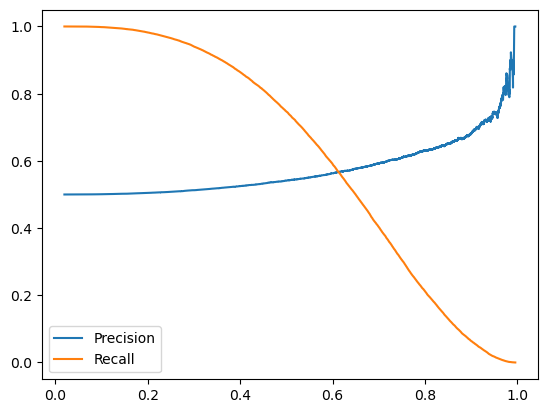

In [76]:
precisions, recalls, thresholds = precision_recall_curve(ytrain_samp, yscores[:, 1])

plt.plot(thresholds, precisions[:-1], label = 'Precision')
plt.plot(thresholds, recalls[:-1], label = 'Recall')
plt.legend();

In [77]:
# Calculate F1 score for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)

optimal_idx = np.argmax(f1_scores)

optimal_threshold = thresholds[optimal_idx]

print(f'Optimal Threshold: {optimal_threshold}')
print(f'Precision: {precisions[optimal_idx]}')
print(f'Recall: {recalls[optimal_idx]}')
print(f'F1 Score: {f1_scores[optimal_idx]}')

# Apply the optimal threshold to convert probabilities to class labels
y_pred = (yscores[:, 1] >= optimal_threshold).astype(int)

Optimal Threshold: 0.14536602795124054
Precision: 0.5022471910112359
Recall: 0.9938720173535792
F1 Score: 0.6672856362643363


In [78]:
test_yscores = final_model.predict_proba(xtest_preprocessed_1)[:, 1]

ypred_80 = (test_yscores >= optimal_threshold)

In [79]:
print(classification_report(ytest, ypred_80))

              precision    recall  f1-score   support

         0.0       0.98      0.01      0.01     86028
         1.0       0.04      1.00      0.07      3254

    accuracy                           0.04     89282
   macro avg       0.51      0.50      0.04     89282
weighted avg       0.95      0.04      0.02     89282



## Evaluation

In [80]:
y_train_pred = final_model.predict(xtrain_samp_1)

y_train_proba = final_model.predict_proba(xtrain_samp_1)[:, 1]

Starting evaluation.....


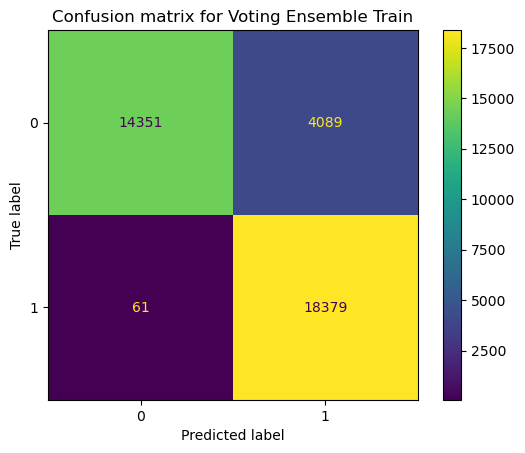

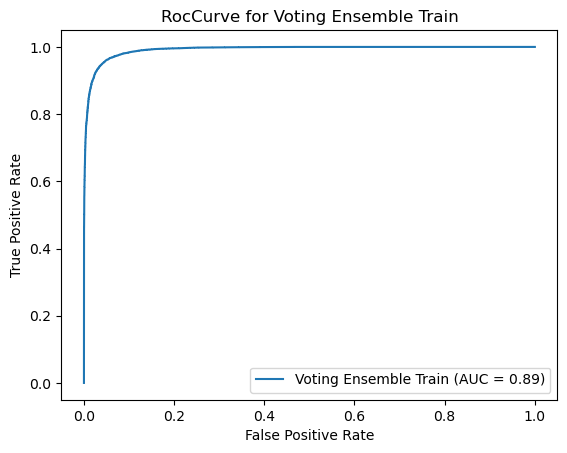

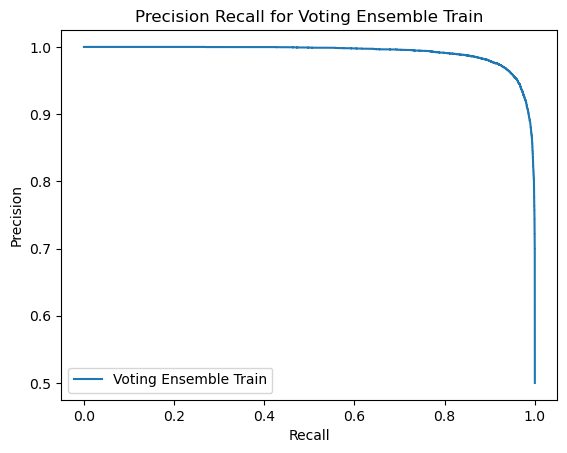

              precision    recall  f1-score   support

         0.0       1.00      0.78      0.87     18440
         1.0       0.82      1.00      0.90     18440

    accuracy                           0.89     36880
   macro avg       0.91      0.89      0.89     36880
weighted avg       0.91      0.89      0.89     36880



,Set type,AUC,F1,Accuracy,Precision,Recall
0,Train,0.887473,0.898553,0.887473,0.818008,0.996692


In [81]:
train_results = evaluate_sets(ytrain_samp, y_train_pred, y_train_proba, 
                              'Train', 'Voting Ensemble Train')

train_results

# Testing

In [82]:
y_test_pred = final_model.predict(xtest_preprocessed_1)

y_test_proba = final_model.predict_proba(xtest_preprocessed_1)[:, 1]

Starting evaluation.....


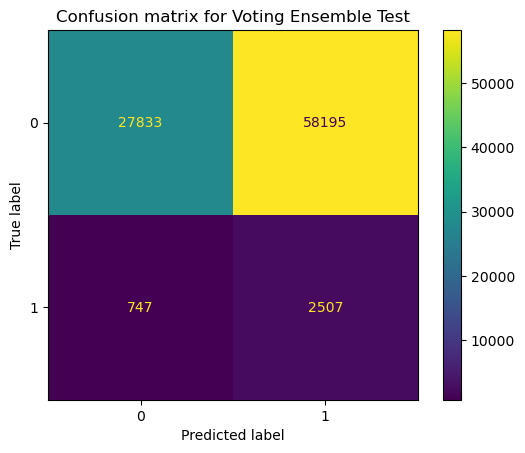

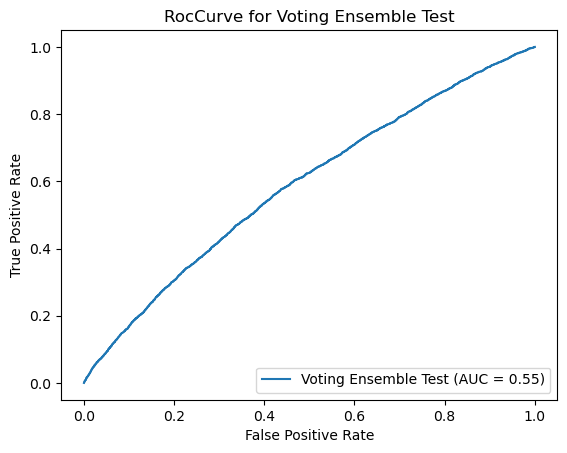

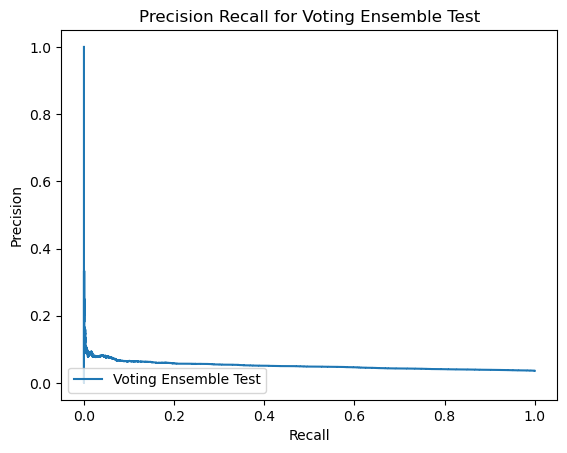

              precision    recall  f1-score   support

         0.0       0.97      0.32      0.49     86028
         1.0       0.04      0.77      0.08      3254

    accuracy                           0.34     89282
   macro avg       0.51      0.55      0.28     89282
weighted avg       0.94      0.34      0.47     89282



,Set type,AUC,F1,Accuracy,Precision,Recall
0,Test,0.546985,0.078398,0.339822,0.0413,0.770436


In [83]:
test_results = evaluate_sets(ytest, y_test_pred, y_test_proba, 
                             'Test', 'Voting Ensemble Test')

test_results 

## Training run 2 - Trying to combat overfitting the minority

- Using Ensembling and Smote

In [84]:
# resample training data

smote = BorderlineSMOTE()

xtrain_samp, ytrain_samp = smote.fit_resample(xtrain_preprocessed, ytrain)

In [85]:
param_grid = {'l1_ratio': np.linspace(0.5, 1.0, 10).tolist(),
             'alpha': np.linspace(0.01, 1.0, 20).tolist()
             }

In [86]:
# elastic net coef

enet = ElasticNet(l1_ratio = 0.5, alpha = 0.01)

grid = GridSearchCV(enet, param_grid, cv = StratifiedKFold(n_splits = 3), scoring = 'f1',refit = True)
grid.fit(xtrain_samp, ytrain_samp)

selected_cols_2 = grid.best_estimator_.coef_

In [87]:
enet_coefs = dict(zip(xtrain_samp.columns, selected_cols_2))

Important_columns = [column for column, value in enet_coefs.items() if abs(value) > 0]

len(Important_columns), len(xtrain_samp.columns)

(23, 57)

In [88]:
xtrain_samp = xtrain_samp[Important_columns]

xtest_preprocessed_2 = xtest_preprocessed[Important_columns]

In [89]:
config['Model Training']['Preprocessor']['Important_columns']['Run_2'] = Important_columns

In [90]:
final_model = xgb.XGBClassifier(**xgboost_best)

In [ ]:
# fit model

final_model.fit(xtrain_samp, ytrain_samp)

## Evaluation

In [ ]:
y_train_pred = final_model.predict(xtrain_samp)

y_train_proba = final_model.predict_proba(xtrain_samp)[:, 1]

In [ ]:
train_results = evaluate_sets(ytrain_samp, y_train_pred, y_train_proba, 
                              'Train', 'Voting Ensemble Train')

train_results

# Testing

In [ ]:
y_test_pred = final_model.predict(xtest_preprocessed_2)

y_test_proba = final_model.predict_proba(xtest_preprocessed_2)[:, 1]

In [ ]:
test_results = evaluate_sets(ytest, y_test_pred, y_test_proba, 
                             'Test', 'Voting Ensemble Test')

test_results 

# Save to config

In [ ]:
# Serializing json
json_object = json.dumps(config, indent=4)
 
# Writing to sample.json
with open("C:/Users/Oamen/OneDrive/Documents/DATA PROJECTS/Insurance_claim_prediction_porto/config.json", "w") as outfile:
    outfile.write(json_object)